In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# XGBoost, DGI-Based Hierarchical Encoding
Mean encode NAICS using DGI blending. Use levels similar to NAICS bas

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
from sklearn.preprocessing import TargetEncoder

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [6]:
import sklearn as sk
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [7]:
from sba_gnn.sba_gnn import sg_plot, sg_blender
from sba_gnn.sba_gnn.sg_blender import HierarchicalEncoder # Target encoder

## Import Processed Datasets

##### Get loans data, append clusters

In [8]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [9]:
sba_loans.filter(like='NAICS').columns

Index(['NAICS', 'NAICS_2', 'NAICS_sector', 'NAICS_sector_desc', 'NAICS_num',
       'NAICS_5', 'NAICS_4', 'NAICS_3', 'menc_NAICS', 'menc_NAICS_5',
       'menc_NAICS_4', 'menc_NAICS_3', 'menc_NAICS_sector', 'mhier_NAICS',
       'cenc_NAICS'],
      dtype='object')

In [10]:
embed_df = pd.read_parquet(Path(setup.temp_path).joinpath('63_DATA_embeddings_tsne_naics.parquet'))

##### NAICS levels to select NAICS-like clusters

In [11]:
naics_grp_stats = pd.read_csv(Path(setup.temp_path).joinpath('02_REPORT_naics_grp_stats_all.csv'))
naics_grp_k = naics_grp_stats['count_grp'].drop_duplicates().sort_values().to_list()
naics_grp_k

[20.0, 106.0, 354.0, 834.0]

In [12]:
cluster_cols = [c for c in embed_df if c.startswith('cluster_')]
cluster_cols

['cluster_003',
 'cluster_010',
 'cluster_020',
 'cluster_106',
 'cluster_354',
 'cluster_834']

In [13]:
cluster_cols_sel = sorted([c for c in cluster_cols if int(c.split('_')[1]) in naics_grp_k],
                         reverse=True)
cluster_cols_sel

['cluster_834', 'cluster_354', 'cluster_106', 'cluster_020']

In [14]:
sba_loans = sba_loans.drop(columns = cluster_cols_sel, errors='ignore') \
    .merge(embed_df[['NAICS_orig'] + cluster_cols_sel] \
               .rename(columns={'NAICS_orig':'NAICS'}),
           on='NAICS', how='left')

In [15]:
sba_loans[cluster_cols_sel[0]].value_counts().head(10)

cluster_834
800    27945
154    19435
198    14235
372    13958
16     12804
8      12327
7       9933
378     9180
584     8837
169     8676
Name: count, dtype: int64

## Fit the Hierarchical Target Encoder
Also save it for later

In [16]:
train_data = sba_loans[sba_loans['dset'] == 'train']
hier_enc = HierarchicalEncoder()
hier_enc.fit(train_data[cluster_cols_sel],train_data['target'])
hier_col = hier_enc.transform(sba_loans[cluster_cols_sel]) \
        .rename('menc_dgi')

In [17]:
with open(Path(setup.temp_path).joinpath('65_DATA_encoder.pkl'), 'wb') as fout:
    pickle.dump(hier_enc, fout)

In [18]:
hier_enc

#### Set the predictor features.  Inlcude the mean-encoded NAICS

In [19]:
sba_loans = pd.concat([sba_loans, hier_col], axis=1)

In [20]:
sba_loans.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv',
       'target', 'guaranteed_fract', 'new_business', 'urban_flag',
       'franchise_flag', 'NAICS_2', 'NAICS_sector', 'NAICS_sector_desc',
       'NAICS_num', 'dset', 'dset_naics_holdout', 'NAICS_5', 'NAICS_4',
       'NAICS_3', 'menc_NAICS', 'menc_NAICS_5', 'menc_NAICS_4', 'menc_NAICS_3',
       'menc_NAICS_sector', 'mhier_NAICS',
       'NS___Accommodation and Food Services',
       'NS___Administrative and Support and Waste Management and Remediation Services',
       'NS___Construction', 'NS___Health Care and Social Assistance',
       'NS___Manufacturing',
       'NS___Other Services (except Public Administra

In [25]:
# Save the new column
sba_loans[['LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'target', 'mhier_NAICS', 'menc_dgi',
          'NAICS']] \
    .to_parquet(Path(setup.temp_path).joinpath('65_DATA_dgi_mhier.parquet'))

In [20]:
sba_loans[['target', 'menc_dgi']].corr()

,target,menc_dgi
target,1.000000,0.222686
menc_dgi,0.222686,1.000000


In [21]:
train_df = sba_loans[sba_loans['dset'] == 'train'].copy()
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

In [22]:
predictor_features = setup.predictor_features + ['menc_dgi']
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'menc_dgi']


In [23]:
with open(Path(setup.temp_path).joinpath('65_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

## Model Fit

In [24]:
best_params_df = pd.read_csv(Path(setup.temp_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

##### Fit using pre-determined parameters

In [25]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [26]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)

In [27]:
xgb_model = xgb_model.set_params(**xgb_params)

In [28]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.50049	validation_1-logloss:0.50406
[1]	validation_0-logloss:0.49311	validation_1-logloss:0.49693
[2]	validation_0-logloss:0.48691	validation_1-logloss:0.49098
[3]	validation_0-logloss:0.48163	validation_1-logloss:0.48592
[4]	validation_0-logloss:0.47721	validation_1-logloss:0.48171
[5]	validation_0-logloss:0.47336	validation_1-logloss:0.47805
[6]	validation_0-logloss:0.47009	validation_1-logloss:0.47496
[7]	validation_0-logloss:0.46728	validation_1-logloss:0.47230
[8]	validation_0-logloss:0.46481	validation_1-logloss:0.46999
[9]	validation_0-logloss:0.46273	validation_1-logloss:0.46807
[10]	validation_0-logloss:0.46091	validation_1-logloss:0.46638
[11]	validation_0-logloss:0.45939	validation_1-logloss:0.46500
[12]	validation_0-logloss:0.45808	validation_1-logloss:0.46382
[13]	validation_0-logloss:0.45692	validation_1-logloss:0.46280
[14]	validation_0-logloss:0.45593	validation_1-logloss:0.46191
[15]	validation_0-logloss:0.45497	validation_1-logloss:0.46109
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [29]:
train_df['target'].value_counts()

target
0    346866
1     89254
Name: count, dtype: int64

##### Save the model

In [30]:
xgb_model.save_model(Path(setup.temp_path).joinpath('65_MODEL_xgboost.json'))

In [31]:
with open(Path(setup.temp_path).joinpath('65_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [32]:
pred_df = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')

In [33]:
pred_df.groupby('target')['predict_prob'].agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
target,,,,,
0,0.183983,0.114966,0.016146,0.647492,0.167696
1,0.281216,0.109653,0.016212,0.669335,0.283855


## Decision Threshold
Max f1, on training data

In [34]:
pred_train_df = pred_df[pred_df['dset'] == 'train']

In [35]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [36]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('65_REPORT_thresh_tune.csv'), index=False)

In [37]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.24


,thresh,f1
12,0.24,0.452202
11,0.22,0.451999


##### Apply decision threshold
All datasets

In [38]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [39]:
pred_df['predict_bin'].value_counts()

predict_bin
0    410067
1    278014
Name: count, dtype: int64

In [40]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('65_DATA_combined_predictions.parquet'))

## Metrics

In [41]:
metrics_dset_df = pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('65_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.677844,0.428687,0.328408,0.617124,0.361704,0.722275,NaN
1,train,0.660545,0.452202,0.337597,0.684608,0.388384,0.733015,NaN
2,val,0.656954,0.447934,0.336237,0.670758,0.379415,0.723758,NaN
0,test,0.656337,0.448569,0.334777,0.679551,0.379871,0.726191,0.0
1,test,0.708741,0.391496,0.315542,0.515608,0.329468,0.714484,1.0


## Lift
Test data

In [42]:
pred_test_df = pred_df[pred_df['dset'] == 'test']

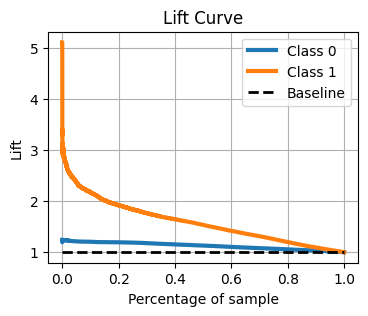

In [43]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('65_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [44]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [45]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('65_REPORT_importance_gain.csv'), index=True)

In [46]:
feat_impgain.head()

,importance
urban_flag,308.449524
LowDoc,126.420319
menc_dgi,85.908852
DisbursementGross,48.965000
CreateJob,20.299299


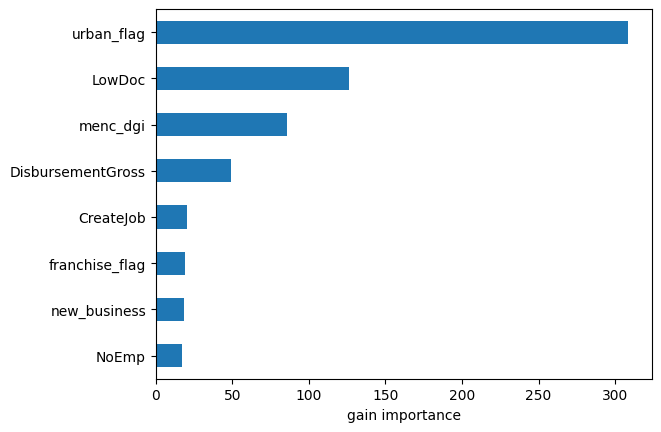

In [47]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('65_PLOT_importance_gain.png'))

##### Permutation Importance

In [48]:
perm_importance = permutation_importance(xgb_model, 
                                         train_df[predictor_features],  train_df['target'],
                                         n_repeats=30, scoring = 'average_precision')

In [49]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [50]:
perm_importance_df.head(5)

,features,importance,abs_importance
7,menc_dgi,0.077711,0.077711
3,DisbursementGross,0.065936,0.065936
5,urban_flag,0.034164,0.034164
1,CreateJob,0.020811,0.020811
2,LowDoc,0.014986,0.014986


In [51]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('65_DATA_importance_perturb.csv'),
            index=False)

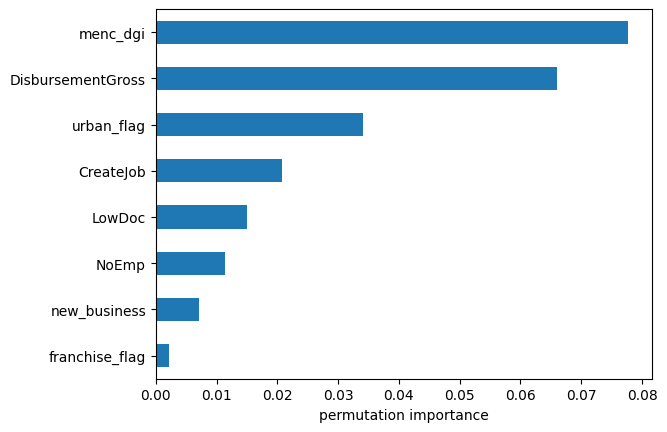

In [52]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('65_PLOT_importance_perturb.png'))

## PDP Plot - NAICS mean encoded

In [53]:
results = partial_dependence(xgb_model, train_df[predictor_features], ['menc_dgi'])
pdp_df = pd.DataFrame({'grid_values':results["grid_values"][0],
                       'pdp':results["average"][0]})

In [54]:
plt.close()

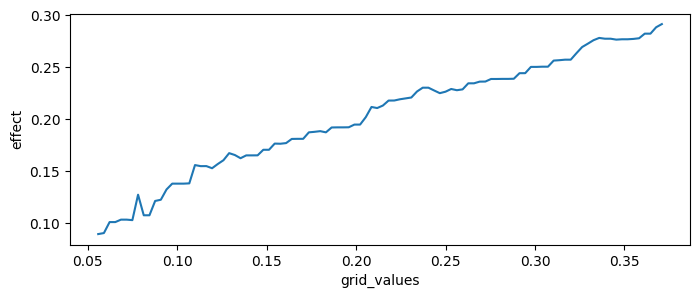

In [55]:
fig, ax = plt.subplots(figsize = (8, 3))
pdp_df.plot(x='grid_values', y='pdp', legend=None, ax=ax)
ax.set_ylabel('effect')
fig.savefig(Path(setup.temp_path).joinpath('65_PLOT_pdp_naics_meanenc.png'),
               bbox_inches='tight')

## NAICS variation plot

In [56]:
embed_df.filter(like='cluster').columns

Index(['cluster', 'cluster_003', 'cluster_010', 'cluster_020', 'cluster_106',
       'cluster_354', 'cluster_834'],
      dtype='object')

In [57]:
sba_loans = sba_loans.drop(columns='cluster', errors='ignore') \
    .merge(embed_df[['NAICS_orig', 'cluster']] \
               .rename(columns={'NAICS_orig':'NAICS'}),
           on='NAICS', how='left')

In [58]:
sba_loans.filter(like='cluster').columns

Index(['cluster_834', 'cluster_354', 'cluster_106', 'cluster_020', 'cluster'], dtype='object')

In [59]:
sba_loans['cluster_desc'] = ''
naics_info = sg_plot.naics_variance_data(sba_loans,
                                        naics_sector_feat='cluster',
                                        naics_sector_desc_feat='cluster_desc')

In [60]:
sba_loans['cluster_desc'] = ''
naics_info_020 = sg_plot.naics_variance_data(sba_loans,
                                        naics_sector_feat='cluster_020',
                                        naics_sector_desc_feat='cluster_desc')

In [61]:
# Plot higher volume NAICS (k=10 cluster)
plt.close()
fig = sg_plot.naics_variance_plot(naics_info[naics_info['count_naics'] >= 100],
                                  naics_sector_feat='cluster',
                                  naics_sector_desc_feat='cluster_desc',
                                  num_sectors=5, xlabel='loan default rate')
fig.savefig(Path(setup.temp_path).joinpath('65_PLOT_naics_counts_rates_100.png'),
           bbox_inches='tight')
plt.close()
fig = sg_plot.naics_variance_plot(naics_info[naics_info['count_naics'] >= 150],
                                  naics_sector_feat='cluster',
                                  naics_sector_desc_feat='cluster_desc',
                                  num_sectors=5, xlabel='loan default rate')
fig.savefig(Path(setup.temp_path).joinpath('65_PLOT_naics_counts_rates_150.png'),
           bbox_inches='tight')
plt.close()

In [62]:
# Plot higher volume NAICS, 20 level cluster
plt.close()
fig = sg_plot.naics_variance_plot(naics_info_020[naics_info_020['count_naics'] >= 100],
                                  naics_sector_feat='cluster_020',
                                  naics_sector_desc_feat='cluster_desc',
                                  num_sectors=5, xlabel='loan default rate')
fig.savefig(Path(setup.temp_path).joinpath('65_PLOT_naics_counts_rates_clus020_100.png'),
           bbox_inches='tight')
plt.close()
fig = sg_plot.naics_variance_plot(naics_info_020[naics_info_020['count_naics'] >= 150],
                                  naics_sector_feat='cluster_020',
                                  naics_sector_desc_feat='cluster_desc',
                                  num_sectors=5, xlabel='loan default rate')
fig.savefig(Path(setup.temp_path).joinpath('65_PLOT_naics_counts_rates_clus020_150.png'),
           bbox_inches='tight')
plt.close()

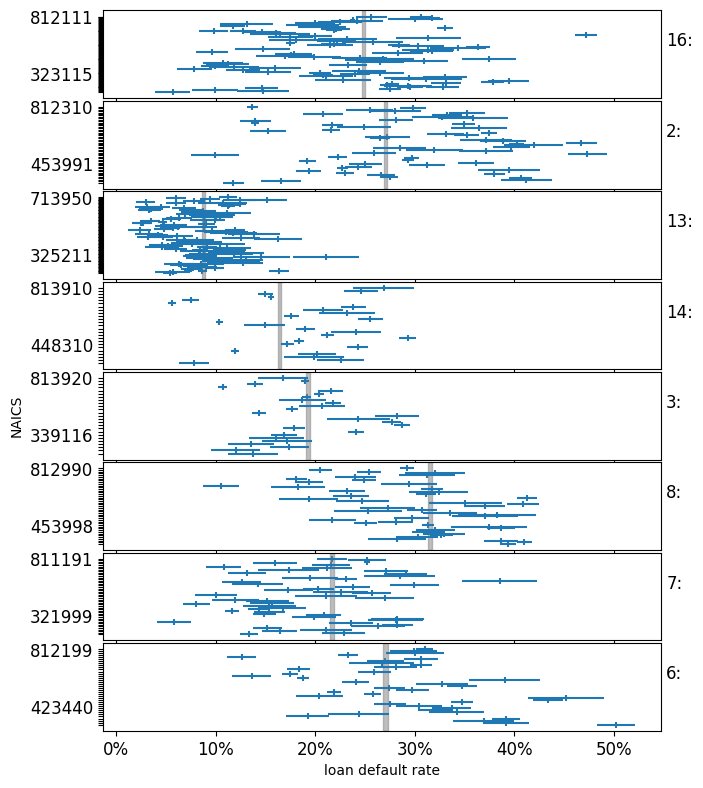

In [63]:
# Plot top 8 volume NAICS, 20 level cluster
plt.close()
fig = sg_plot.naics_variance_plot(naics_info_020[naics_info_020['count_naics'] >= 100],
                                  naics_sector_feat='cluster_020',
                                  naics_sector_desc_feat='cluster_desc',
                                  num_sectors=8, xlabel='loan default rate')
fig.savefig(Path(setup.temp_path).joinpath('65_PLOT_naics_counts_rates_clus020_100_top_8.png'),
           bbox_inches='tight')
plt.close()
fig = sg_plot.naics_variance_plot(naics_info_020[naics_info_020['count_naics'] >= 150],
                                  naics_sector_feat='cluster_020',
                                  naics_sector_desc_feat='cluster_desc',
                                  num_sectors=8, xlabel='loan default rate')
fig.savefig(Path(setup.temp_path).joinpath('65_PLOT_naics_counts_rates_clus020_150_top_8.png'),
           bbox_inches='tight')